# Live Code 1 Phase 1

## Perkenalan

Nama: Judan Syamsul Hadad
Batch: FTDS-009

## Soal Nomor 1

Buatlah model linear regression untuk memprediksi closing price saham Amazon ([Dataset URL](https://www.kaggle.com/dgawlik/nyse?select=prices-split-adjusted.csv)). Gunakan file `prices-split-adjusted.csv` dalam kasus ini.

### Import Pustaka

In [430]:
#General Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Regression
from sklearn.linear_model import LinearRegression, LogisticRegression

#Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from feature_engine.outliers import Winsorizer

#Evaluation
from sklearn.metrics import r2_score, classification_report

### Data Loading

Load dataset.

In [376]:
df1 = pd.read_csv('prices-split-adjusted.csv')
df1.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


Cek properties dataset.

In [377]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


Cek statistika deskriptif dataset.

In [378]:
df1.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


Cek jumlah nilai unik dari masing-masing feature.

In [379]:
df1.nunique()

date        1762
symbol       501
open       97522
close      98520
low        97470
high       97784
volume    171073
dtype: int64

Cek duplikat.

In [380]:
df1.duplicated().sum()

0

### Exploratory Data Analysis (EDA)

Cek hubungan antar variabel.

<AxesSubplot:>

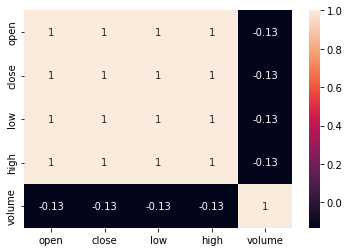

In [381]:
sns.heatmap(df1.corr(),annot=True)

Kecuali volume, feature lain memiliki korelasi sangat kuat dan dapat mempengaruhi model.

### Data Preprocessing

#### Cardinality

Tidak ada karena kategorikal semua.

#### Filtering Data

Filter data khusus Amazon.

In [382]:
df_amzn = df1[df1['symbol']=='AMZN']

#### Data Splitting

Ubah `date` menjadi index.

In [383]:
df_amzn.set_index('date',inplace=True)

Split data inferential.

In [384]:
data_inf = df_amzn.sample(3,random_state=34)
df_amzn_split = df_amzn.drop(index=data_inf.index)

Deklarasi X dan y.

In [385]:
y = df_amzn_split['close']
X = df_amzn_split.drop(columns=['close','symbol'])

Split train dan test set.

In [386]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=34)

#### Handling Outlier

Buat fungsi untuk deteksi outlier.

In [387]:
#deteksi outlier untuk distribusi normal

def find_normal_boundaries(dataframe, variable):
    upper_boundary = dataframe[variable].mean() + 3 * dataframe[variable].std()
    lower_boundary = dataframe[variable].mean() - 3 * dataframe[variable].std()

    return upper_boundary, lower_boundary

In [388]:
#deteksi outlier untuk distribusi skewed

def find_skewed_boundaries(dataframe, variable):
    Q1 = dataframe[variable].quantile(0.25)
    Q3 = dataframe[variable].quantile(0.75)
    IQR = Q3 - Q1
    upper_boundary = Q3 + 1.5 * IQR
    lower_boundary = Q1 - 1.5 * IQR

    return upper_boundary, lower_boundary

Rangkum outlier.

In [389]:
skewnewss = []
upper_limit = []
lower_limit = []
outlier_percent = []
max = []
min = []

for column in X_train.columns:
    col_max = X_train[column].max()
    col_min = X_train[column].min()
    col_skewness = X_train[column].skew()

    if (col_skewness >= -0.5) & (col_skewness <= 0.5) :
        col_upper, col_lower = find_normal_boundaries(X_train,column)
    else:
        col_upper, col_lower = find_skewed_boundaries(X_train,column)

    col_outliers_percent = (len(X_train[X_train[column] > col_upper]) + len(X_train[X_train[column] < col_lower])) / len(X_train) * 100

    skewnewss.append(col_skewness)
    upper_limit.append(col_upper)
    max.append(col_max)
    min.append(col_min)
    lower_limit.append(col_lower)
    outlier_percent.append(col_outliers_percent)

outliers_summary = {'skewness':skewnewss, 'upper_limit':upper_limit, 'max':max,'lower_limit':lower_limit, 'min':min,'percent_outlier':outlier_percent}
outliers_summary = round(pd.DataFrame(outliers_summary,index=X_train.columns),2)

In [390]:
outliers_summary

,skewness,upper_limit,max,lower_limit,min,percent_outlier
open,1.07,713.13,845.79,-118.17,105.93,9.24
low,1.08,704.08,840.27,-116.68,105.80,9.45
high,1.07,716.11,845.95,-115.81,112.53,9.45
volume,4.25,9376725.00,42421100.00,-1246675.00,1091200.00,5.76


Nilainya tidak terpantau selisih jauh dan secara nilai saham masih dalam batas wajar sehingga akan dibiarkan tanpa capping/trimming.

#### Handling Missing Value

Cek missing value di X dan y.

In [391]:
X_train.isna().sum()

open      0
low       0
high      0
volume    0
dtype: int64

In [392]:
y_train.isna().sum()

0

Tidak ada missing value.

#### Feature Selection

Cek ulang heatmap.

<AxesSubplot:>

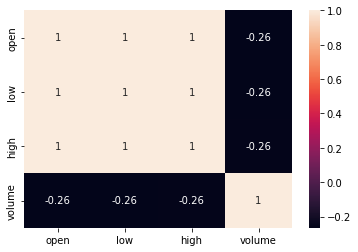

In [393]:
sns.heatmap(X_train.corr(),annot=True)

Kalau dilihat, `low`, `high`, dan `open` memiliki korelasi antar feature sangat kuat dan akan mempengaruhi model yang dibuat.

#### Feature Scaling

Pada regresi linier, data train perlu diubah menggunakan StandarScaler.

In [394]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Feature Encoding

Tidak ada feature encoding karena tidak ada feature kategorik.

### Model Definition

Model yang dipakai ada Linear Regression tanpa regularisasi. Model ini dipilih untuk memastikan semua feature dipertimbangkan di dalam model. Hyperparameter yang digunakan hanya fit_intercept karena tidak diketahui apakah dataset centered atau tidak. Evaluasi model ini akan menggunakan metrics R2 score karena nilai metrics-nya selalu dalam rentang 0-1 untuk tiap model sehingga lebih mudah mengatakan jika suatu model baik atau buruk.

In [395]:
linreg = LinearRegression(fit_intercept=True)

### Model Training

In [396]:
linreg.fit(X_train_scaled,y_train)

y_train_pred = linreg.predict(X_train_scaled)
y_test_pred = linreg.predict(X_test_scaled)

### Model Evaluation

Cek R2 score dari model untuk train dan test.

In [397]:
print('R2 score train:',r2_score(y_train,y_train_pred))
print('R2 score test:',r2_score(y_test,y_test_pred))

R2 score train: 0.9998662860634208
R2 score test: 0.9998218438024836


Kalau kita lihat akurasinya tinggi sekali. Hal ini disebabkan oleh pengaruh variabel dengan korelasi yang tinggi. Berikut koefisiennya.

In [398]:
X_train.columns.tolist()

['open', 'low', 'high', 'volume']

In [399]:
linreg.coef_

array([-1.13865090e+02,  1.40644459e+02,  1.65439919e+02,  1.77226513e-02])

Feature selain `volume` memiliki koefisien yang besar sekali.

### Model Inference

Cek dengan data inference.

In [400]:
data_inf.drop(columns='symbol',inplace=True)

In [401]:
data_inf.head()

,open,close,low,high,volume
date,,,,,
2012-11-13,225.119995,226.600006,224.710007,227.899994,2629800.0
2010-10-27,168.910004,167.509995,166.539993,169.750000,5721800.0
2015-06-05,429.660004,426.950012,426.500000,430.799988,1907900.0


In [402]:
X_inf = data_inf.drop('close',axis=1)

In [403]:
X_inf_scaled = scaler.transform(X_inf)

In [404]:
y_inf = linreg.predict(X_inf_scaled)

In [405]:
data_inf['close-pred'] = y_inf

In [406]:
data_inf

,open,close,low,high,volume,close-pred
date,,,,,,
2012-11-13,225.119995,226.600006,224.710007,227.899994,2629800.0,227.043283
2010-10-27,168.910004,167.509995,166.539993,169.750000,5721800.0,167.747837
2015-06-05,429.660004,426.950012,426.500000,430.799988,1907900.0,428.146645


Hasil prediksinya terlihat sesuai karena bias dari variabel open, low, dan high.

 ### Pengambilan Kesimpulan

Model ini sebaiknya tidak dipakai dan dilakukan training ulang dengan feature hanya `volume` saja.

## Soal Nomor 2

Buatlah visualisasi yang menampilkan closing price saham `Amazon`, `Cisco`, `Apple`, dan `Netflix` berdasarkan `date` (time series). Saham apa yang memiliki closing price tertinggi dan terendah di akhir tahun 2014, 2015 dan 2016?

Library dan dataset menggunakan dari Soal Nomor 1.

In [407]:
#ubah tanggal ke format datetime
df1['date'] = pd.to_datetime(df1['date'])

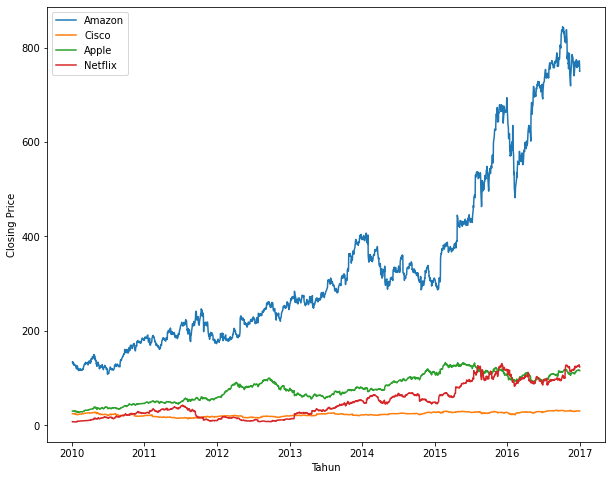

In [408]:
#buat plot dengan x berupa tanggal dan y berupa closing price
plt.figure(figsize=(10,8))
plt.plot(df1[df1['symbol']=='AMZN']['date'],df1[df1['symbol']=='AMZN']['close'],label='Amazon')
plt.plot(df1[df1['symbol']=='CSCO']['date'],df1[df1['symbol']=='CSCO']['close'],label='Cisco')
plt.plot(df1[df1['symbol']=='AAPL']['date'],df1[df1['symbol']=='AAPL']['close'],label='Apple')
plt.plot(df1[df1['symbol']=='NFLX']['date'],df1[df1['symbol']=='NFLX']['close'],label='Netflix')
plt.xlabel('Tahun')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

Closing price saham tertinggi di tiap akhir tahun selalu dipegang oleh `Amazon`, sedangkan yang terendah selalu dipegang oleh `Cisco`.

## Soal Nomor 3

Buatlah model Logistic Regression untuk memprediksi Loan Pay Back ([Dataset URL](https://www.kaggle.com/sarahvch/predicting-who-pays-back-loans?select=loan_data.csv)). Gunakan file `loan_data.csv` dalam kasus ini.

### Import Pustaka
Library yang digunakan sama dengan Soal Nomor 1.

### Data Loading

Load dataset.

In [409]:
df2 = pd.read_csv('loan_data.csv')
df2.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


Cek properties dataset.

In [410]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


Cek statistika deskriptif dataset.

In [411]:
df2.describe()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


Cek jumlah nilai unik di dataset.

In [412]:
df2.nunique()

credit.policy           2
purpose                 7
int.rate              249
installment          4788
log.annual.inc       1987
dti                  2529
fico                   44
days.with.cr.line    2687
revol.bal            7869
revol.util           1035
inq.last.6mths         28
delinq.2yrs            11
pub.rec                 6
not.fully.paid          2
dtype: int64

Cek duplikat pada dataset.

In [413]:
df2.duplicated().sum()

0

### Exploratory Data Analysis (EDA)

<AxesSubplot:>

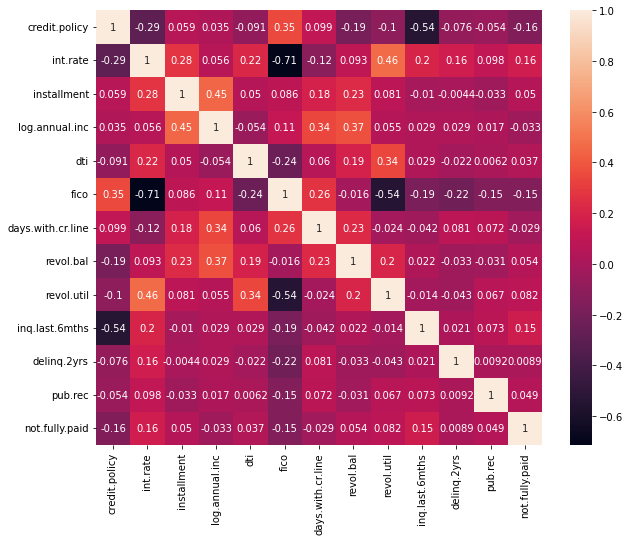

In [414]:
plt.figure(figsize=(10,8))
sns.heatmap(df2.corr(),annot=True)

Tidak terlihat ada feature yang memiliki korelasi sangat kuat pada `not.fully.paid`.

### Data Preprocessing

Ambil data inference.

In [415]:
df2.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


In [416]:
data_inf2 = df2.sample(3,random_state=34)
df2_proses = df2.drop(index=data_inf2.index)

Split Train Test.

In [417]:
y = df2_proses['not.fully.paid']

In [418]:
X = df2_proses.drop('not.fully.paid',axis=1)

In [419]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=34)

In [420]:
X_train_cat = X_train[['credit.policy','purpose','inq.last.6mths','delinq.2yrs','pub.rec']]

In [421]:
X_train_num = X_train.drop(columns=['credit.policy','purpose','inq.last.6mths','delinq.2yrs','pub.rec'])

In [425]:
X_test_cat = X_test[['credit.policy','purpose','inq.last.6mths','delinq.2yrs','pub.rec']]

In [426]:
X_test_num = X_test.drop(columns=['credit.policy','purpose','inq.last.6mths','delinq.2yrs','pub.rec'])

Encoding

In [444]:
X_test_cat

,credit.policy,purpose,inq.last.6mths,delinq.2yrs,pub.rec
9301,0,home_improvement,4,0,0
181,1,all_other,0,0,1
3956,1,credit_card,0,1,0
2463,1,all_other,3,1,0
5052,1,all_other,0,0,0
...,...,...,...,...,...
6152,1,credit_card,3,0,0
8009,0,debt_consolidation,4,0,0
6639,1,debt_consolidation,0,0,0
4435,1,credit_card,2,0,0


In [445]:
encoder = OrdinalEncoder()
encoder.fit(X_train_cat)

X_train_cat = encoder.transform(X_train_cat)
# X_test_cat = encoder.transform(X_test_cat)

Scaling

In [435]:
X_train_num

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util
9498,0.1426,267.59,9.878170,15.45,707,1710.041667,3910,38.2
3012,0.0963,481.42,10.666627,10.49,777,6329.958333,4963,15.8
6219,0.0894,381.26,10.768485,2.78,782,5405.000000,6877,20.0
725,0.1166,115.69,10.901598,12.38,672,7530.041667,0,0.0
7078,0.1645,530.67,11.153819,11.02,662,7830.041667,16478,84.9
...,...,...,...,...,...,...,...,...
5669,0.1322,540.81,11.396392,5.66,732,5160.041667,6847,75.2
325,0.1014,485.00,11.388450,13.73,732,5489.000000,14903,35.3
3159,0.0963,96.29,10.858999,12.00,742,4020.000000,5689,30.0
5995,0.0894,133.45,11.407565,19.24,727,4200.041667,15366,50.9


In [437]:
scaler.fit(X_train_num)

X_train_scaled = scaler.transform(X_train_num)
X_test_scaled = scaler.transform(X_test_num)

In [438]:
X_train_final = np.concatenate([X_train_scaled,X_train_cat],axis=1)

In [439]:
X_test_final = np.concatenate([X_test_scaled,X_test_cat],axis=1)

### Model Definition

In [440]:
logreg = LogisticRegression(solver='liblinear',C=1)

### Model Training

In [441]:
logreg.fit(X_train_final,y_train)

LogisticRegression(C=1, solver='liblinear')

In [446]:
y_train_pred = logreg.predict(X_train_final)


Test set menghasilkan error karena ada kategori yang tidak termasuk di dalam train set saat training.

In [ ]:
# y_test_pred = logreg.predict(X_test_final)

### Model Evaluation

In [447]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      6415
           1       0.42      0.02      0.03      1245

    accuracy                           0.84      7660
   macro avg       0.63      0.51      0.47      7660
weighted avg       0.77      0.84      0.77      7660



Model bisa memprediksi dengan baik untuk train set. Test set tidak dapat dicek karena ada data kategorik yang tidak masuk dalam training.

### Model Inference

In [448]:
data_inf2

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
1836,1,debt_consolidation,0.1411,229.34,10.646615,23.67,667,4980.041667,10106,40.3,1,0,0,0
180,1,credit_card,0.1028,485.99,11.385092,11.95,702,5070.000000,24615,94.7,0,0,0,0
8720,0,debt_consolidation,0.1450,258.16,11.918391,26.27,697,5070.000000,91148,95.4,2,0,0,0


### Pengambilan Kesimpulan

Implementasi model ini tidak akan berfungsi karena ada kategori pada test set yang tidak terdapat pada train set. Harus dilakukan stratifikasi saat splitting train test agar semua kategori ada di masing-masing set train, test, dan inference.

## Soal Nomor 4

Dengan dataset nomor 3, carilah jumlah `fully paid` tertinggi dan terendah berdasarkan `purpose`. 

Library dan dataset menggunakan dari Soal Nomor 1.

Asumsi `not.fully.paid = 1` adalah gagal membayar.

In [422]:
#hitung debt terlebih dahulu
df2['debt'] = df2['dti'] * np.exp(df2['log.annual.inc'])

Berikut rangkuman `debt` di masing-masing kategori purpose.

In [423]:
df2[(df2['not.fully.paid']==0)&df2['debt']>0][['purpose','debt']].groupby('purpose').aggregate(['min','max'])

debt              
                             min           max
purpose                                       
all_other            2713.199988  4.772500e+06
credit_card         11894.999969  5.413500e+06
debt_consolidation   1152.000001  6.748000e+06
educational          7307.999974  3.235632e+06
home_improvement    10399.999962  6.345000e+06
major_purchase       5880.000013  4.395230e+06
small_business       1199.999999  8.634000e+06